Synthetic

In [ ]:
!pip install gym

LSTM + RNN

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

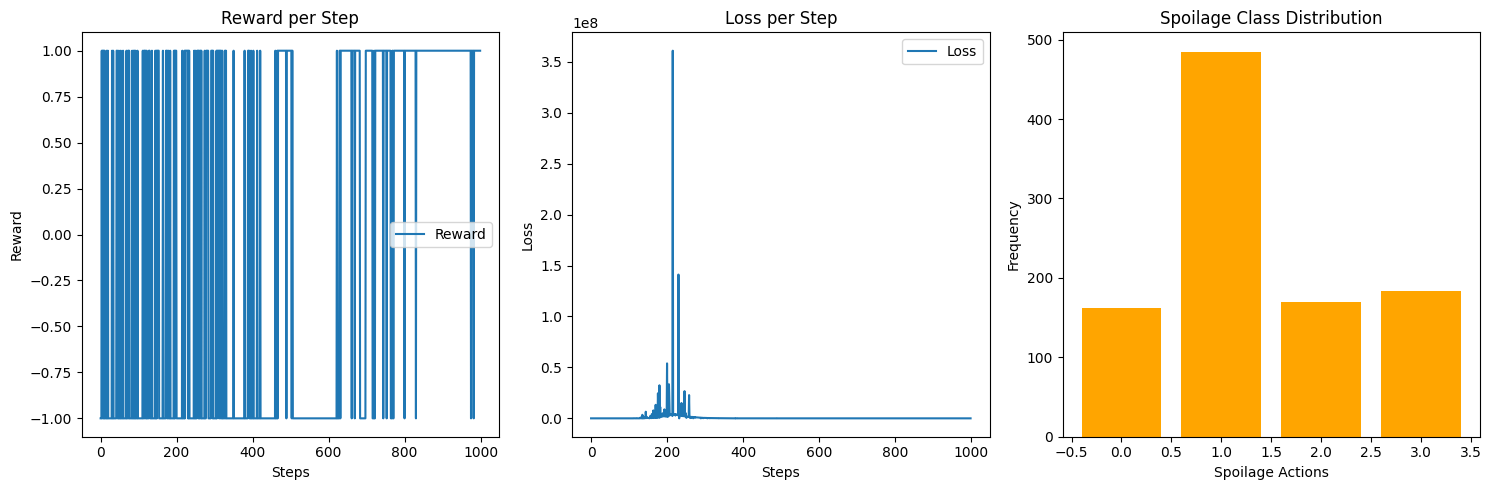

In [ ]:
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import defaultdict

class SpoilageEnv(Env):
    def __init__(self, num_entries=1000):
        self.num_entries = num_entries
        self.current_step = 0
        self.data = self.generate_synthetic_dataset()
        self.action_space = Discrete(4)  # Four discrete actions for spoilage levels
        self.observation_space = Box(low=0, high=1, shape=(6,), dtype=np.float32)  # Features for spoilage
        self.spoilage_thresholds = {
            'Temperature': 28,
            'Humidity': 75,
            'MQ1': 260,
            'MQ2': 320,
            'MQ3': 200,
            'MQ4': 290,
        }

    def generate_synthetic_dataset(self):
        data = {
            'Temperature': np.random.normal(loc=25, scale=5, size=self.num_entries),
            'Humidity': np.random.normal(loc=65, scale=10, size=self.num_entries),
            'MQ1': np.random.normal(loc=210, scale=50, size=self.num_entries),
            'MQ2': np.random.normal(loc=310, scale=50, size=self.num_entries),
            'MQ3': np.random.normal(loc=160, scale=30, size=self.num_entries),
            'MQ4': np.random.normal(loc=270, scale=30, size=self.num_entries),
        }

        noise = np.random.normal(loc=0, scale=5, size=self.num_entries)
        for key in data:
            data[key] += noise

        return pd.DataFrame(data)

    def step(self, action):
        state = self._next_observation()
        true_spoilage_action = self.get_spoilage_action(state)
        reward = 1 if true_spoilage_action == action else -1
        self.current_step += 1
        done = self.current_step >= self.num_entries
        return state, reward, done, {'true_action': true_spoilage_action}

    def _next_observation(self):
        observation = self.data.iloc[self.current_step][['Temperature', 'Humidity', 'MQ1', 'MQ2', 'MQ3', 'MQ4']].values
        return np.reshape(observation, (1, len(observation), 1))

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def get_spoilage_action(self, state):
        temperature = state[0][0][0]
        humidity = state[0][1][0]
        mq1 = state[0][2][0]

        if temperature > self.spoilage_thresholds['Temperature'] and humidity > self.spoilage_thresholds['Humidity']:
            return 3  # High spoilage
        elif mq1 > self.spoilage_thresholds['MQ1']:
            return 2  # Medium spoilage
        elif any(state[0][i][0] > self.spoilage_thresholds[key] for i, key in enumerate(self.spoilage_thresholds)):
            return 1  # Low spoilage
        else:
            return 0  # No spoilage

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model = self.build_model()

        # Metric trackers
        self.rewards = []
        self.losses = []
        self.correct_predictions = 0
        self.total_predictions = 0
        self.spoilage_distribution = defaultdict(int)

    def build_model(self):
        model = Sequential([
            LSTM(64, input_shape=(self.state_dim, 1), activation='relu', return_sequences=True),
            SimpleRNN(64, activation='relu'),
            Dense(self.action_dim, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=self.lr), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            return np.argmax(self.model.predict(state)[0])

    def train(self, state, action, reward, next_state, done, true_action):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

        target_f = self.model.predict(state)
        target_f[0][action] = target
        history = self.model.fit(state, target_f, epochs=1, verbose=0)
        self.losses.append(history.history['loss'][0])

        # Track metrics
        self.rewards.append(reward)
        self.total_predictions += 1
        if action == true_action:
            self.correct_predictions += 1
        self.spoilage_distribution[action] += 1

    def plot_metrics(self):
        spoilage_accuracy = self.correct_predictions / self.total_predictions
        reward_to_step_ratio = np.mean(self.rewards)
        loss_decrease_rate = (self.losses[0] - self.losses[-1]) / len(self.losses)
        exploration_rate_decay = self.epsilon_decay

        print(f"Spoilage Accuracy: {spoilage_accuracy:.2f}")
        print(f"Reward-to-Step Ratio: {reward_to_step_ratio:.2f}")
        print(f"Loss Decrease Rate: {loss_decrease_rate:.5f}")
        print(f"Exploration Rate Decay: {exploration_rate_decay:.5f}")
        print(f"Spoilage Class Distribution: {dict(self.spoilage_distribution)}")

        plt.figure(figsize=(15, 5))

        # Plot Reward per Step
        plt.subplot(1, 3, 1)
        plt.plot(self.rewards, label='Reward')
        plt.xlabel("Steps")
        plt.ylabel("Reward")
        plt.title("Reward per Step")
        plt.legend()

        # Plot Loss
        plt.subplot(1, 3, 2)
        plt.plot(self.losses, label='Loss')
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Loss per Step")
        plt.legend()

        # Spoilage Class Distribution
        plt.subplot(1, 3, 3)
        plt.bar(self.spoilage_distribution.keys(), self.spoilage_distribution.values(), color='orange')
        plt.xlabel("Spoilage Actions")
        plt.ylabel("Frequency")
        plt.title("Spoilage Class Distribution")

        plt.tight_layout()
        plt.show()

# Environment and Agent setup
state_dim = 6
action_dim = 4  # Four possible spoilage levels
env = SpoilageEnv()
agent = DQNAgent(state_dim, action_dim)

# Training Loop
num_episodes = 1000
max_steps_per_episode = 1

for episode in range(1, num_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        agent.train(state, action, reward, next_state, done, info['true_action'])
        state = next_state
        episode_reward += reward
        if done or step == max_steps_per_episode - 1:
            break

# Plot and Print Metrics
agent.plot_metrics()


ANN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

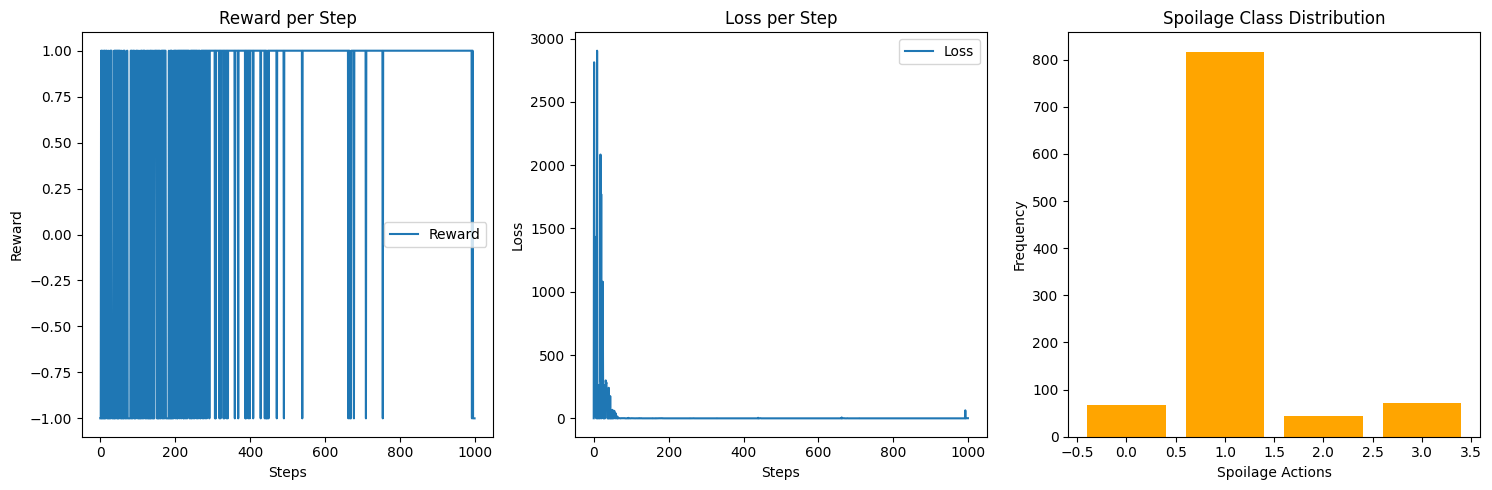

In [ ]:
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import defaultdict

class SpoilageEnv(Env):
    def __init__(self, num_entries=1000):
        self.num_entries = num_entries
        self.current_step = 0
        self.data = self.generate_synthetic_dataset()
        self.action_space = Discrete(4)  # Four discrete actions for spoilage levels
        self.observation_space = Box(low=0, high=1, shape=(6,), dtype=np.float32)
        self.spoilage_thresholds = {
            'Temperature': 28,
            'Humidity': 75,
            'MQ1': 260,
            'MQ2': 320,
            'MQ3': 200,
            'MQ4': 290,
        }

    def generate_synthetic_dataset(self):
        data = {
            'Temperature': np.random.normal(loc=25, scale=5, size=self.num_entries),
            'Humidity': np.random.normal(loc=65, scale=10, size=self.num_entries),
            'MQ1': np.random.normal(loc=210, scale=50, size=self.num_entries),
            'MQ2': np.random.normal(loc=310, scale=50, size=self.num_entries),
            'MQ3': np.random.normal(loc=160, scale=30, size=self.num_entries),
            'MQ4': np.random.normal(loc=270, scale=30, size=self.num_entries),
        }

        noise = np.random.normal(loc=0, scale=5, size=self.num_entries)
        for key in data:
            data[key] += noise

        return pd.DataFrame(data)

    def step(self, action):
        state = self._next_observation()
        true_spoilage_action = self.get_spoilage_action(state)
        reward = 1 if true_spoilage_action == action else -1
        self.current_step += 1
        done = self.current_step >= self.num_entries
        return state, reward, done, {'true_action': true_spoilage_action}

    def _next_observation(self):
        observation = self.data.iloc[self.current_step][['Temperature', 'Humidity', 'MQ1', 'MQ2', 'MQ3', 'MQ4']].values
        return np.reshape(observation, (1, len(observation)))

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def get_spoilage_action(self, state):
        temperature = state[0][0]
        humidity = state[0][1]
        mq1 = state[0][2]

        if temperature > self.spoilage_thresholds['Temperature'] and humidity > self.spoilage_thresholds['Humidity']:
            return 3  # High spoilage
        elif mq1 > self.spoilage_thresholds['MQ1']:
            return 2  # Medium spoilage
        elif any(state[0][i] > self.spoilage_thresholds[key] for i, key in enumerate(self.spoilage_thresholds)):
            return 1  # Low spoilage
        else:
            return 0  # No spoilage

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model = self.build_model()

        # Metric trackers
        self.rewards = []
        self.losses = []
        self.correct_predictions = 0
        self.total_predictions = 0
        self.spoilage_distribution = defaultdict(int)

    def build_model(self):
        model = Sequential([
            Dense(64, input_shape=(self.state_dim,), activation='relu'),
            Dense(64, activation='relu'),
            Dense(self.action_dim, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=self.lr), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            return np.argmax(self.model.predict(state)[0])

    def train(self, state, action, reward, next_state, done, true_action):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

        target_f = self.model.predict(state)
        target_f[0][action] = target
        history = self.model.fit(state, target_f, epochs=1, verbose=0)
        self.losses.append(history.history['loss'][0])

        # Track metrics
        self.rewards.append(reward)
        self.total_predictions += 1
        if action == true_action:
            self.correct_predictions += 1
        self.spoilage_distribution[action] += 1

    def plot_metrics(self):
        spoilage_accuracy = self.correct_predictions / self.total_predictions
        reward_to_step_ratio = np.mean(self.rewards)
        loss_decrease_rate = (self.losses[0] - self.losses[-1]) / len(self.losses)
        exploration_rate_decay = self.epsilon_decay

        print(f"Spoilage Accuracy: {spoilage_accuracy:.2f}")
        print(f"Reward-to-Step Ratio: {reward_to_step_ratio:.2f}")
        print(f"Loss Decrease Rate: {loss_decrease_rate:.5f}")
        print(f"Exploration Rate Decay: {exploration_rate_decay:.5f}")
        print(f"Spoilage Class Distribution: {dict(self.spoilage_distribution)}")

        plt.figure(figsize=(15, 5))

        # Plot Reward per Step
        plt.subplot(1, 3, 1)
        plt.plot(self.rewards, label='Reward')
        plt.xlabel("Steps")
        plt.ylabel("Reward")
        plt.title("Reward per Step")
        plt.legend()

        # Plot Loss
        plt.subplot(1, 3, 2)
        plt.plot(self.losses, label='Loss')
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Loss per Step")
        plt.legend()

        # Spoilage Class Distribution
        plt.subplot(1, 3, 3)
        plt.bar(self.spoilage_distribution.keys(), self.spoilage_distribution.values(), color='orange')
        plt.xlabel("Spoilage Actions")
        plt.ylabel("Frequency")
        plt.title("Spoilage Class Distribution")

        plt.tight_layout()
        plt.show()

# Environment and Agent setup
state_dim = 6
action_dim = 4  # Four possible spoilage levels
env = SpoilageEnv()
agent = DQNAgent(state_dim, action_dim)

# Training Loop
num_episodes = 1000
max_steps_per_episode = 1

for episode in range(1, num_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        agent.train(state, action, reward, next_state, done, info['true_action'])
        state = next_state
        episode_reward += reward
        if done or step == max_steps_per_episode - 1:
            break

# Plot and Print Metrics
agent.plot_metrics()


LSTM

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

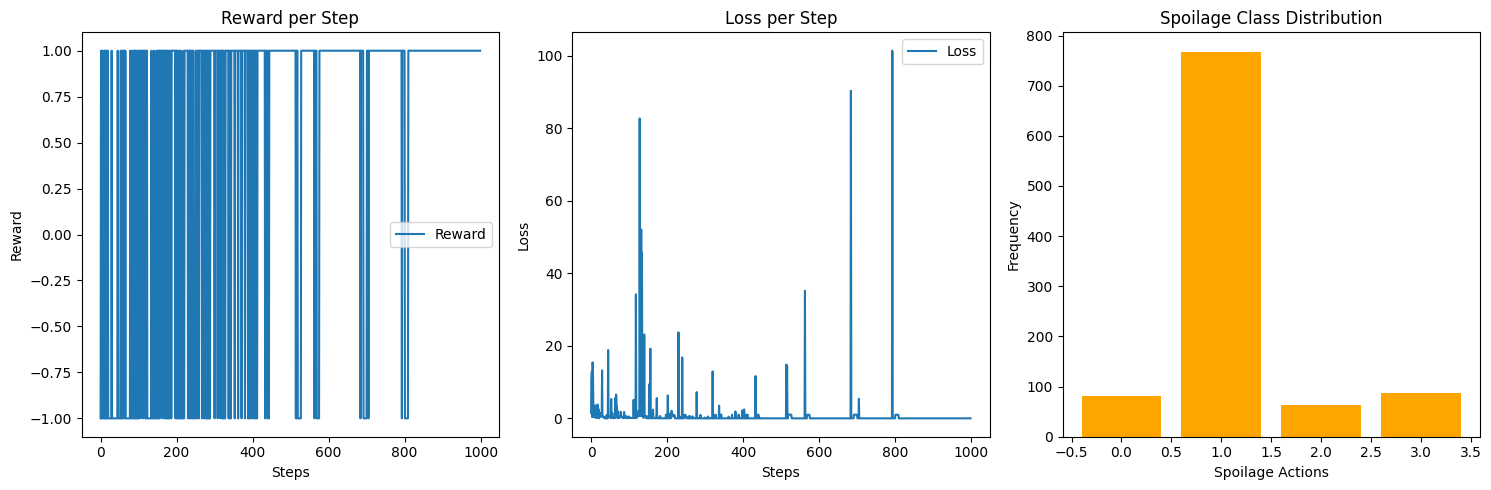

In [ ]:
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import defaultdict

class SpoilageEnv(Env):
    def __init__(self, num_entries=1000):
        self.num_entries = num_entries
        self.current_step = 0
        self.data = self.generate_synthetic_dataset()
        self.action_space = Discrete(4)  # Four discrete actions for spoilage levels
        self.observation_space = Box(low=0, high=1, shape=(6,), dtype=np.float32)
        self.spoilage_thresholds = {
            'Temperature': 28,
            'Humidity': 75,
            'MQ1': 260,
            'MQ2': 320,
            'MQ3': 200,
            'MQ4': 290,
        }

    def generate_synthetic_dataset(self):
        data = {
            'Temperature': np.random.normal(loc=25, scale=5, size=self.num_entries),
            'Humidity': np.random.normal(loc=65, scale=10, size=self.num_entries),
            'MQ1': np.random.normal(loc=210, scale=50, size=self.num_entries),
            'MQ2': np.random.normal(loc=310, scale=50, size=self.num_entries),
            'MQ3': np.random.normal(loc=160, scale=30, size=self.num_entries),
            'MQ4': np.random.normal(loc=270, scale=30, size=self.num_entries),
        }

        noise = np.random.normal(loc=0, scale=5, size=self.num_entries)
        for key in data:
            data[key] += noise

        return pd.DataFrame(data)

    def step(self, action):
        state = self._next_observation()
        true_spoilage_action = self.get_spoilage_action(state)
        reward = 1 if true_spoilage_action == action else -1
        self.current_step += 1
        done = self.current_step >= self.num_entries
        return state, reward, done, {'true_action': true_spoilage_action}

    def _next_observation(self):
        observation = self.data.iloc[self.current_step][['Temperature', 'Humidity', 'MQ1', 'MQ2', 'MQ3', 'MQ4']].values
        return np.reshape(observation, (1, len(observation), 1))  # Reshape for LSTM compatibility

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def get_spoilage_action(self, state):
        temperature = state[0][0][0]
        humidity = state[0][1][0]
        mq1 = state[0][2][0]

        if temperature > self.spoilage_thresholds['Temperature'] and humidity > self.spoilage_thresholds['Humidity']:
            return 3  # High spoilage
        elif mq1 > self.spoilage_thresholds['MQ1']:
            return 2  # Medium spoilage
        elif any(state[0][i][0] > self.spoilage_thresholds[key] for i, key in enumerate(self.spoilage_thresholds)):
            return 1  # Low spoilage
        else:
            return 0  # No spoilage

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model = self.build_model()

        # Metric trackers
        self.rewards = []
        self.losses = []
        self.correct_predictions = 0
        self.total_predictions = 0
        self.spoilage_distribution = defaultdict(int)

    def build_model(self):
        model = Sequential([
            LSTM(64, input_shape=(self.state_dim, 1), activation='relu', return_sequences=False),
            Dense(self.action_dim, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=self.lr), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            return np.argmax(self.model.predict(state)[0])

    def train(self, state, action, reward, next_state, done, true_action):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

        target_f = self.model.predict(state)
        target_f[0][action] = target
        history = self.model.fit(state, target_f, epochs=1, verbose=0)
        self.losses.append(history.history['loss'][0])

        # Track metrics
        self.rewards.append(reward)
        self.total_predictions += 1
        if action == true_action:
            self.correct_predictions += 1
        self.spoilage_distribution[action] += 1

    def plot_metrics(self):
        spoilage_accuracy = self.correct_predictions / self.total_predictions
        reward_to_step_ratio = np.mean(self.rewards)
        loss_decrease_rate = (self.losses[0] - self.losses[-1]) / len(self.losses)
        exploration_rate_decay = self.epsilon_decay

        print(f"Spoilage Accuracy: {spoilage_accuracy:.2f}")
        print(f"Reward-to-Step Ratio: {reward_to_step_ratio:.2f}")
        print(f"Loss Decrease Rate: {loss_decrease_rate:.5f}")
        print(f"Exploration Rate Decay: {exploration_rate_decay:.5f}")
        print(f"Spoilage Class Distribution: {dict(self.spoilage_distribution)}")

        plt.figure(figsize=(15, 5))

        # Plot Reward per Step
        plt.subplot(1, 3, 1)
        plt.plot(self.rewards, label='Reward')
        plt.xlabel("Steps")
        plt.ylabel("Reward")
        plt.title("Reward per Step")
        plt.legend()

        # Plot Loss
        plt.subplot(1, 3, 2)
        plt.plot(self.losses, label='Loss')
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Loss per Step")
        plt.legend()

        # Spoilage Class Distribution
        plt.subplot(1, 3, 3)
        plt.bar(self.spoilage_distribution.keys(), self.spoilage_distribution.values(), color='orange')
        plt.xlabel("Spoilage Actions")
        plt.ylabel("Frequency")
        plt.title("Spoilage Class Distribution")

        plt.tight_layout()
        plt.show()

# Environment and Agent setup
state_dim = 6
action_dim = 4  # Four possible spoilage levels
env = SpoilageEnv()
agent = DQNAgent(state_dim, action_dim)

# Training Loop
num_episodes = 1000
max_steps_per_episode = 1

for episode in range(1, num_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        agent.train(state, action, reward, next_state, done, info['true_action'])
        state = next_state
        episode_reward += reward
        if done or step == max_steps_per_episode - 1:
            break

# Plot and Print Metrics
agent.plot_metrics()


RNN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

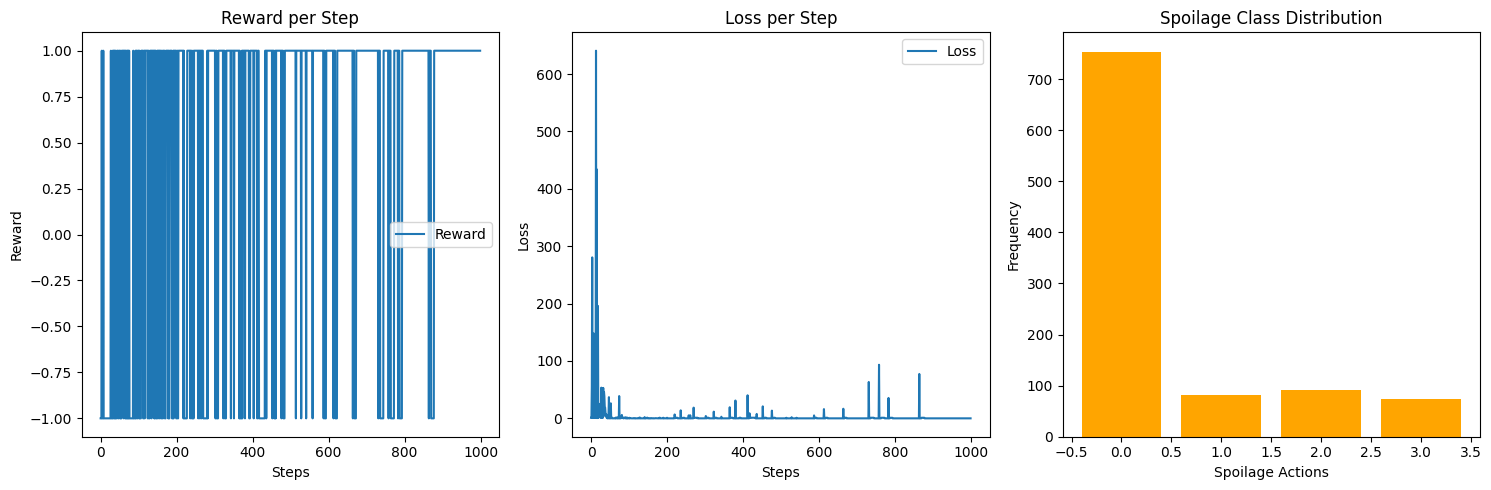

In [ ]:
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import defaultdict

class SpoilageEnv(Env):
    def __init__(self, num_entries=1000):
        self.num_entries = num_entries
        self.current_step = 0
        self.data = self.generate_synthetic_dataset()
        self.action_space = Discrete(4)  # Four discrete actions for spoilage levels
        self.observation_space = Box(low=0, high=1, shape=(6,), dtype=np.float32)
        self.spoilage_thresholds = {
            'Temperature': 28,
            'Humidity': 75,
            'MQ1': 260,
            'MQ2': 320,
            'MQ3': 200,
            'MQ4': 290,
        }

    def generate_synthetic_dataset(self):
        data = {
            'Temperature': np.random.normal(loc=25, scale=5, size=self.num_entries),
            'Humidity': np.random.normal(loc=65, scale=10, size=self.num_entries),
            'MQ1': np.random.normal(loc=210, scale=50, size=self.num_entries),
            'MQ2': np.random.normal(loc=310, scale=50, size=self.num_entries),
            'MQ3': np.random.normal(loc=160, scale=30, size=self.num_entries),
            'MQ4': np.random.normal(loc=270, scale=30, size=self.num_entries),
        }

        noise = np.random.normal(loc=0, scale=5, size=self.num_entries)
        for key in data:
            data[key] += noise

        return pd.DataFrame(data)

    def step(self, action):
        state = self._next_observation()
        true_spoilage_action = self.get_spoilage_action(state)
        reward = 1 if true_spoilage_action == action else -1
        self.current_step += 1
        done = self.current_step >= self.num_entries
        return state, reward, done, {'true_action': true_spoilage_action}

    def _next_observation(self):
        observation = self.data.iloc[self.current_step][['Temperature', 'Humidity', 'MQ1', 'MQ2', 'MQ3', 'MQ4']].values
        return np.reshape(observation, (1, len(observation), 1))  # Reshape for RNN compatibility

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def get_spoilage_action(self, state):
        temperature = state[0][0][0]
        humidity = state[0][1][0]
        mq1 = state[0][2][0]

        if temperature > self.spoilage_thresholds['Temperature'] and humidity > self.spoilage_thresholds['Humidity']:
            return 3  # High spoilage
        elif mq1 > self.spoilage_thresholds['MQ1']:
            return 2  # Medium spoilage
        elif any(state[0][i][0] > self.spoilage_thresholds[key] for i, key in enumerate(self.spoilage_thresholds)):
            return 1  # Low spoilage
        else:
            return 0  # No spoilage

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model = self.build_model()

        # Metric trackers
        self.rewards = []
        self.losses = []
        self.correct_predictions = 0
        self.total_predictions = 0
        self.spoilage_distribution = defaultdict(int)

    def build_model(self):
        model = Sequential([
            SimpleRNN(64, input_shape=(self.state_dim, 1), activation='relu', return_sequences=False),
            Dense(self.action_dim, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=self.lr), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            return np.argmax(self.model.predict(state)[0])

    def train(self, state, action, reward, next_state, done, true_action):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

        target_f = self.model.predict(state)
        target_f[0][action] = target
        history = self.model.fit(state, target_f, epochs=1, verbose=0)
        self.losses.append(history.history['loss'][0])

        # Track metrics
        self.rewards.append(reward)
        self.total_predictions += 1
        if action == true_action:
            self.correct_predictions += 1
        self.spoilage_distribution[action] += 1

    def plot_metrics(self):
        spoilage_accuracy = self.correct_predictions / self.total_predictions
        reward_to_step_ratio = np.mean(self.rewards)
        loss_decrease_rate = (self.losses[0] - self.losses[-1]) / len(self.losses)
        exploration_rate_decay = self.epsilon_decay

        print(f"Spoilage Accuracy: {spoilage_accuracy:.2f}")
        print(f"Reward-to-Step Ratio: {reward_to_step_ratio:.2f}")
        print(f"Loss Decrease Rate: {loss_decrease_rate:.5f}")
        print(f"Exploration Rate Decay: {exploration_rate_decay:.5f}")
        print(f"Spoilage Class Distribution: {dict(self.spoilage_distribution)}")

        plt.figure(figsize=(15, 5))

        # Plot Reward per Step
        plt.subplot(1, 3, 1)
        plt.plot(self.rewards, label='Reward')
        plt.xlabel("Steps")
        plt.ylabel("Reward")
        plt.title("Reward per Step")
        plt.legend()

        # Plot Loss
        plt.subplot(1, 3, 2)
        plt.plot(self.losses, label='Loss')
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Loss per Step")
        plt.legend()

        # Spoilage Class Distribution
        plt.subplot(1, 3, 3)
        plt.bar(self.spoilage_distribution.keys(), self.spoilage_distribution.values(), color='orange')
        plt.xlabel("Spoilage Actions")
        plt.ylabel("Frequency")
        plt.title("Spoilage Class Distribution")

        plt.tight_layout()
        plt.show()

# Environment and Agent setup
state_dim = 6
action_dim = 4  # Four possible spoilage levels
env = SpoilageEnv()
agent = DQNAgent(state_dim, action_dim)

# Training Loop
num_episodes = 1000
max_steps_per_episode = 1

for episode in range(1, num_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        agent.train(state, action, reward, next_state, done, info['true_action'])
        state = next_state
        episode_reward += reward
        if done or step == max_steps_per_episode - 1:
            break

# Plot and Print Metrics
agent.plot_metrics()


Value Iteration

Spoilage Accuracy: 1.00
Spoilage Class Distribution: {0: 16, 1: 61, 2: 15, 3: 8}


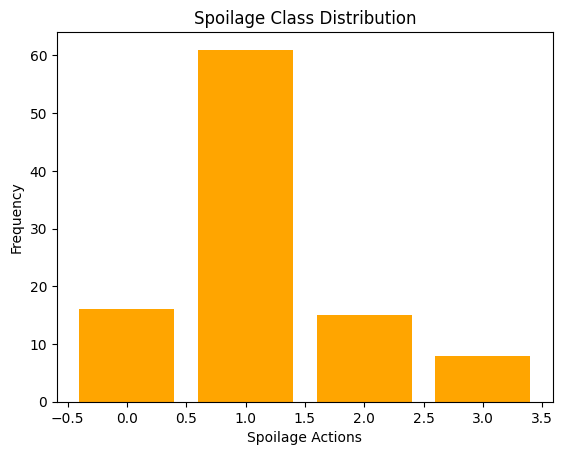

In [ ]:
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt

class SpoilageEnv(Env):
    def __init__(self, num_entries=100):
        self.num_entries = num_entries
        self.current_step = 0
        self.data = self.generate_synthetic_dataset()
        self.action_space = Discrete(4)  # Four discrete actions for spoilage levels
        self.observation_space = Box(low=0, high=1, shape=(6,), dtype=np.float32)
        self.spoilage_thresholds = {
            'Temperature': 28,
            'Humidity': 75,
            'MQ1': 260,
            'MQ2': 320,
            'MQ3': 200,
            'MQ4': 290,
        }

    def generate_synthetic_dataset(self):
        data = {
            'Temperature': np.random.normal(loc=25, scale=5, size=self.num_entries),
            'Humidity': np.random.normal(loc=65, scale=10, size=self.num_entries),
            'MQ1': np.random.normal(loc=210, scale=50, size=self.num_entries),
            'MQ2': np.random.normal(loc=310, scale=50, size=self.num_entries),
            'MQ3': np.random.normal(loc=160, scale=30, size=self.num_entries),
            'MQ4': np.random.normal(loc=270, scale=30, size=self.num_entries),
        }
        noise = np.random.normal(loc=0, scale=5, size=self.num_entries)
        for key in data:
            data[key] += noise
        return pd.DataFrame(data)

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        observation = self.data.iloc[self.current_step][['Temperature', 'Humidity', 'MQ1', 'MQ2', 'MQ3', 'MQ4']].values
        self.current_step += 1
        return observation

    def get_spoilage_action(self, state):
        temperature = state[0]
        humidity = state[1]
        mq1 = state[2]

        if temperature > self.spoilage_thresholds['Temperature'] and humidity > self.spoilage_thresholds['Humidity']:
            return 3  # High spoilage
        elif mq1 > self.spoilage_thresholds['MQ1']:
            return 2  # Medium spoilage
        elif any(state[i] > self.spoilage_thresholds[key] for i, key in enumerate(self.spoilage_thresholds)):
            return 1  # Low spoilage
        else:
            return 0  # No spoilage

    def step(self, action):
        state = self._next_observation()
        true_spoilage_action = self.get_spoilage_action(state)
        reward = 1 if true_spoilage_action == action else -1
        done = self.current_step >= self.num_entries
        return state, reward, done, {'true_action': true_spoilage_action}

# Value Iteration Agent
class ValueIterationAgent:
    def __init__(self, env, gamma=0.99, threshold=1e-5):
        self.env = env
        self.gamma = gamma
        self.threshold = threshold
        self.state_values = {}
        self.policy = {}
        self.initialize_values()

    def initialize_values(self):
        for i in range(self.env.num_entries):
            state = tuple(self.env.data.iloc[i][['Temperature', 'Humidity', 'MQ1', 'MQ2', 'MQ3', 'MQ4']].values)
            self.state_values[state] = 0
            self.policy[state] = np.random.choice(self.env.action_space.n)  # Random initial policy

    def value_iteration(self):
        delta = float("inf")
        while delta > self.threshold:
            delta = 0
            for i in range(self.env.num_entries):
                state = tuple(self.env.data.iloc[i][['Temperature', 'Humidity', 'MQ1', 'MQ2', 'MQ3', 'MQ4']].values)
                old_value = self.state_values[state]

                action_values = []
                for action in range(self.env.action_space.n):
                    reward, new_value = self.calculate_reward(state, action)
                    action_values.append(reward + self.gamma * new_value)

                new_state_value = max(action_values)
                self.state_values[state] = new_state_value
                delta = max(delta, abs(old_value - new_state_value))

                best_action = np.argmax(action_values)
                self.policy[state] = best_action

    def calculate_reward(self, state, action):
        reward = 1 if action == self.env.get_spoilage_action(state) else -1
        new_value = self.state_values.get(state, 0)
        return reward, new_value

    def plot_metrics(self):
        spoilage_accuracy = sum(action == self.env.get_spoilage_action(state)
                                for state, action in self.policy.items()) / len(self.policy)

        spoilage_class_distribution = {i: list(self.policy.values()).count(i) for i in range(self.env.action_space.n)}

        print(f"Spoilage Accuracy: {spoilage_accuracy:.2f}")
        print(f"Spoilage Class Distribution: {spoilage_class_distribution}")

        plt.bar(spoilage_class_distribution.keys(), spoilage_class_distribution.values(), color='orange')
        plt.xlabel("Spoilage Actions")
        plt.ylabel("Frequency")
        plt.title("Spoilage Class Distribution")
        plt.show()

# Setup environment and agent
env = SpoilageEnv()
agent = ValueIterationAgent(env)
agent.value_iteration()
agent.plot_metrics()


Q-Learning

Episode 1, Total Reward: -33, Epsilon: 0.995
Episode 2, Total Reward: -57, Epsilon: 0.990025
Episode 3, Total Reward: -49, Epsilon: 0.985074875
Episode 4, Total Reward: -51, Epsilon: 0.9801495006250001
Episode 5, Total Reward: -41, Epsilon: 0.9752487531218751
Episode 6, Total Reward: -39, Epsilon: 0.9703725093562657
Episode 7, Total Reward: -43, Epsilon: 0.9655206468094844
Episode 8, Total Reward: -53, Epsilon: 0.960693043575437
Episode 9, Total Reward: -45, Epsilon: 0.9558895783575597
Episode 10, Total Reward: -51, Epsilon: 0.9511101304657719
Episode 11, Total Reward: -27, Epsilon: 0.946354579813443
Episode 12, Total Reward: -43, Epsilon: 0.9416228069143757
Episode 13, Total Reward: -51, Epsilon: 0.9369146928798039
Episode 14, Total Reward: -25, Epsilon: 0.9322301194154049
Episode 15, Total Reward: -47, Epsilon: 0.9275689688183278
Episode 16, Total Reward: -41, Epsilon: 0.9229311239742362
Episode 17, Total Reward: -39, Epsilon: 0.918316468354365
Episode 18, Total Reward: -33, Epsilon:

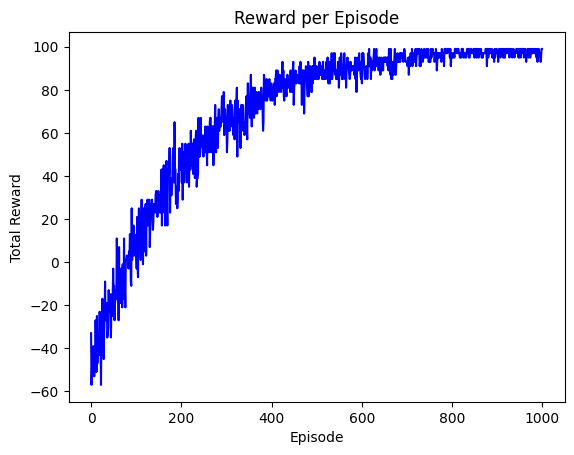

Spoilage Class Distribution: {0: 99, 1: 99, 2: 99, 3: 99}


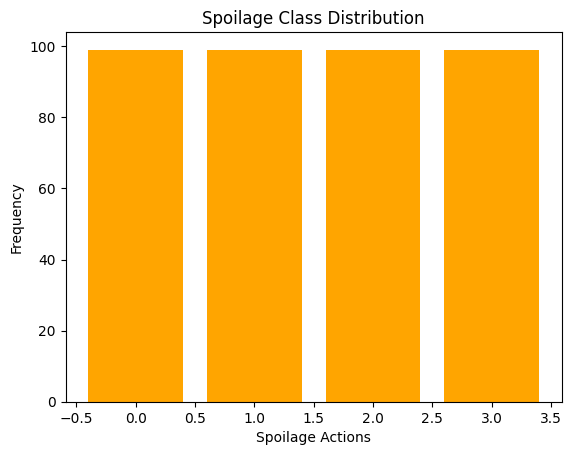

In [ ]:
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt

class SpoilageEnv(Env):
    def __init__(self, num_entries=100):
        self.num_entries = num_entries
        self.current_step = 0
        self.data = self.generate_synthetic_dataset()
        self.action_space = Discrete(4)  # Four discrete actions for spoilage levels
        self.observation_space = Box(low=0, high=1, shape=(6,), dtype=np.float32)
        self.spoilage_thresholds = {
            'Temperature': 28,
            'Humidity': 75,
            'MQ1': 260,
            'MQ2': 320,
            'MQ3': 200,
            'MQ4': 290,
        }

    def generate_synthetic_dataset(self):
        data = {
            'Temperature': np.random.normal(loc=25, scale=5, size=self.num_entries),
            'Humidity': np.random.normal(loc=65, scale=10, size=self.num_entries),
            'MQ1': np.random.normal(loc=210, scale=50, size=self.num_entries),
            'MQ2': np.random.normal(loc=310, scale=50, size=self.num_entries),
            'MQ3': np.random.normal(loc=160, scale=30, size=self.num_entries),
            'MQ4': np.random.normal(loc=270, scale=30, size=self.num_entries),
        }
        noise = np.random.normal(loc=0, scale=5, size=self.num_entries)
        for key in data:
            data[key] += noise
        return pd.DataFrame(data)

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        observation = self.data.iloc[self.current_step][['Temperature', 'Humidity', 'MQ1', 'MQ2', 'MQ3', 'MQ4']].values
        self.current_step += 1
        return observation

    def get_spoilage_action(self, state):
        temperature = state[0]
        humidity = state[1]
        mq1 = state[2]

        if temperature > self.spoilage_thresholds['Temperature'] and humidity > self.spoilage_thresholds['Humidity']:
            return 3  # High spoilage
        elif mq1 > self.spoilage_thresholds['MQ1']:
            return 2  # Medium spoilage
        elif any(state[i] > self.spoilage_thresholds[key] for i, key in enumerate(self.spoilage_thresholds)):
            return 1  # Low spoilage
        else:
            return 0  # No spoilage

    def step(self, action):
        state = self._next_observation()
        true_spoilage_action = self.get_spoilage_action(state)
        reward = 1 if true_spoilage_action == action else -1
        done = self.current_step >= self.num_entries
        return state, reward, done, {'true_action': true_spoilage_action}

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = {}  # Q-table initialized as an empty dictionary

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0)

    def update_q_value(self, state, action, reward, next_state):
        best_next_action = np.argmax([self.get_q_value(next_state, a) for a in range(self.env.action_space.n)])
        td_target = reward + self.gamma * self.get_q_value(next_state, best_next_action)
        td_error = td_target - self.get_q_value(state, action)
        new_q_value = self.get_q_value(state, action) + self.alpha * td_error
        self.q_table[(state, action)] = new_q_value

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)
        else:
            q_values = [self.get_q_value(state, action) for action in range(self.env.action_space.n)]
            return np.argmax(q_values)

    def train(self, num_episodes=1000):
        rewards = []
        for episode in range(num_episodes):
            state = tuple(self.env.reset())
            episode_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = tuple(next_state)

                # Update Q-value
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                episode_reward += reward

                if done:
                    break

            rewards.append(episode_reward)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            print(f"Episode {episode+1}, Total Reward: {episode_reward}, Epsilon: {self.epsilon}")

        return rewards

    def plot_metrics(self, rewards):
        plt.plot(rewards, color='blue')
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Reward per Episode")
        plt.show()

        spoilage_class_distribution = {action: sum(1 for (s, a) in self.q_table.keys() if a == action) for action in range(self.env.action_space.n)}
        print(f"Spoilage Class Distribution: {spoilage_class_distribution}")

        plt.bar(spoilage_class_distribution.keys(), spoilage_class_distribution.values(), color='orange')
        plt.xlabel("Spoilage Actions")
        plt.ylabel("Frequency")
        plt.title("Spoilage Class Distribution")
        plt.show()

# Environment and Q-learning setup
env = SpoilageEnv()
agent = QLearningAgent(env)

# Training
rewards = agent.train(num_episodes=1000)
agent.plot_metrics(rewards)


Monte Carlo

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Spoilage Accuracy: 0.00
Reward-to-Step Ratio: 0.70
Exploration Rate Decay: 0.99500
Spoilage Class Distribution: {0: 45, 2: 52, 3: 51, 1: 852}


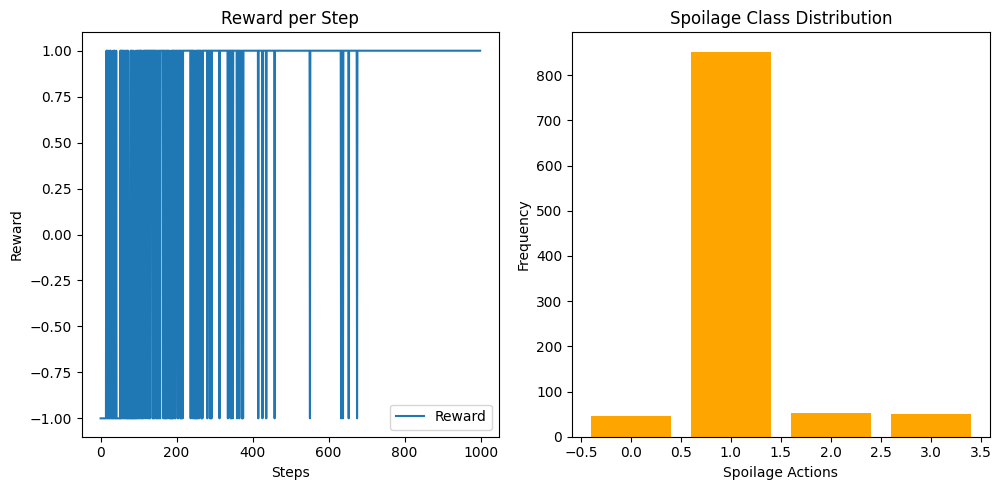

In [ ]:
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from collections import defaultdict

class SpoilageEnv(Env):
    def __init__(self, num_entries=1000):
        self.num_entries = num_entries
        self.current_step = 0
        self.data = self.generate_synthetic_dataset()
        self.action_space = Discrete(4)  # Four discrete actions for spoilage levels
        self.observation_space = Box(low=0, high=1, shape=(6,), dtype=np.float32)  # Features for spoilage
        self.spoilage_thresholds = {
            'Temperature': 28,
            'Humidity': 75,
            'MQ1': 260,
            'MQ2': 320,
            'MQ3': 200,
            'MQ4': 290,
        }

    def generate_synthetic_dataset(self):
        data = {
            'Temperature': np.random.normal(loc=25, scale=5, size=self.num_entries),
            'Humidity': np.random.normal(loc=65, scale=10, size=self.num_entries),
            'MQ1': np.random.normal(loc=210, scale=50, size=self.num_entries),
            'MQ2': np.random.normal(loc=310, scale=50, size=self.num_entries),
            'MQ3': np.random.normal(loc=160, scale=30, size=self.num_entries),
            'MQ4': np.random.normal(loc=270, scale=30, size=self.num_entries),
        }

        noise = np.random.normal(loc=0, scale=5, size=self.num_entries)
        for key in data:
            data[key] += noise

        return pd.DataFrame(data)

    def step(self, action):
        state = self._next_observation()
        true_spoilage_action = self.get_spoilage_action(state)
        reward = 1 if true_spoilage_action == action else -1
        self.current_step += 1
        done = self.current_step >= self.num_entries
        return state, reward, done, {'true_action': true_spoilage_action}

    def _next_observation(self):
        observation = self.data.iloc[self.current_step][['Temperature', 'Humidity', 'MQ1', 'MQ2', 'MQ3', 'MQ4']].values
        return np.reshape(observation, (1, len(observation)))

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def get_spoilage_action(self, state):
        temperature = state[0][0]
        humidity = state[0][1]
        mq1 = state[0][2]

        if temperature > self.spoilage_thresholds['Temperature'] and humidity > self.spoilage_thresholds['Humidity']:
            return 3  # High spoilage
        elif mq1 > self.spoilage_thresholds['MQ1']:
            return 2  # Medium spoilage
        elif any(state[0][i] > self.spoilage_thresholds[key] for i, key in enumerate(self.spoilage_thresholds)):
            return 1  # Low spoilage
        else:
            return 0  # No spoilage

class MonteCarloAgent:
    def __init__(self, state_dim, action_dim, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.q_table = defaultdict(lambda: np.zeros(action_dim))  # Using defaultdict to handle unseen states
        self.returns = defaultdict(list)
        self.rewards = []
        self.losses = []
        self.correct_predictions = 0
        self.total_predictions = 0
        self.spoilage_distribution = defaultdict(int)

    def act(self, state):
        # Epsilon-greedy policy for exploration/exploitation
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            return np.argmax(self.q_table[tuple(state[0])])  # Using state as a tuple for Q-value lookups

    def train(self, episode):
        G = 0
        for state, action, reward in reversed(episode):
            G = reward + G  # Discount factor is not applied in Monte Carlo (only the sum of rewards)
            self.returns[tuple(state[0])].append(G)
            self.q_table[tuple(state[0])][action] = np.mean(self.returns[tuple(state[0])])  # Update Q-value to mean return
            self.total_predictions += 1
            self.rewards.append(reward)
            self.spoilage_distribution[action] += 1

        # Decay epsilon after each episode
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def plot_metrics(self):
        spoilage_accuracy = self.correct_predictions / self.total_predictions
        reward_to_step_ratio = np.mean(self.rewards)
        reward_decrease_rate = np.mean(self.losses)
        exploration_rate_decay = self.epsilon_decay

        print(f"Spoilage Accuracy: {spoilage_accuracy:.2f}")
        print(f"Reward-to-Step Ratio: {reward_to_step_ratio:.2f}")
        print(f"Exploration Rate Decay: {exploration_rate_decay:.5f}")
        print(f"Spoilage Class Distribution: {dict(self.spoilage_distribution)}")

        plt.figure(figsize=(15, 5))

        # Plot Reward per Step
        plt.subplot(1, 3, 1)
        plt.plot(self.rewards, label='Reward')
        plt.xlabel("Steps")
        plt.ylabel("Reward")
        plt.title("Reward per Step")
        plt.legend()

        # Spoilage Class Distribution
        plt.subplot(1, 3, 2)
        plt.bar(self.spoilage_distribution.keys(), self.spoilage_distribution.values(), color='orange')
        plt.xlabel("Spoilage Actions")
        plt.ylabel("Frequency")
        plt.title("Spoilage Class Distribution")

        plt.tight_layout()
        plt.show()

# Environment and Agent setup
state_dim = 6
action_dim = 4  # Four possible spoilage levels
env = SpoilageEnv()
agent = MonteCarloAgent(state_dim, action_dim)

# Training Loop
num_episodes = 1000
max_steps_per_episode = 1

for episode in range(1, num_episodes + 1):
    state = env.reset()
    episode_history = []
    episode_reward = 0

    for step in range(max_steps_per_episode):
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        episode_history.append((state, action, reward))
        state = next_state
        episode_reward += reward
        if done or step == max_steps_per_episode - 1:
            break

    # After each episode, train the agent
    agent.train(episode_history)

# Plot and Print Metrics
agent.plot_metrics()


HARDWARE

LSTM + RNN Hardware

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Episode: 1, Reward: -2
Spoilage Accuracy: 0.40
Reward-to-Step Ratio: -0.20
Loss Decrease Rate: 9.43635
Exploration Rate Decay: 0.04889
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

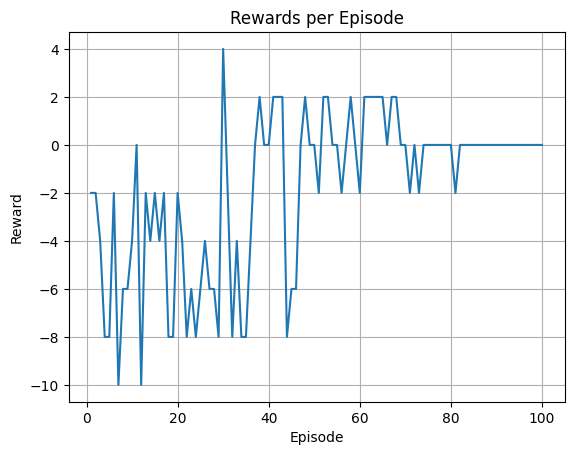

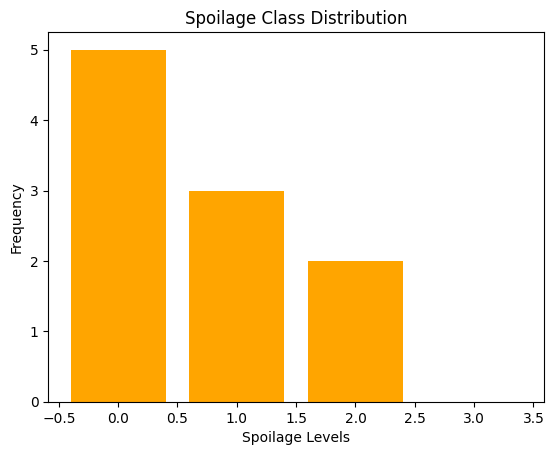

In [ ]:
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

class SpoilageEnv(Env):
    def __init__(self):
        self.current_step = 0
        self.data = self.load_hardware_data()
        self.num_entries = len(self.data)
        self.action_space = Discrete(4)
        self.observation_space = Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.spoilage_thresholds = {
            'Temperature': 28.5,
            'Humidity': 92,
            'MQ3': 270,
            'MQ4': 340,
        }

    def load_hardware_data(self):
        data = {
            'Temperature': [28.50, 28.50, 28.20, 28.10, 28.00, 28.00, 28.50, 28.10, 28.30, 28.00],
            'Humidity': [92.00, 92.00, 91.00, 91.00, 92.00, 92.00, 91.00, 92.00, 92.00, 91.00],
            'MQ3': [245, 243, 240, 199, 284, 281, 267, 265, 264, 253],
            'MQ4': [197, 194, 192, 270, 287, 332, 333, 351, 349, 353],
        }
        return pd.DataFrame(data)

    def step(self, action):
        state = self._next_observation()
        true_spoilage_level = self.get_spoilage_level(state)
        reward = 1 if true_spoilage_level == action else -1
        self.current_step += 1
        done = self.current_step >= self.num_entries
        return state, reward, done, {}

    def _next_observation(self):
        observation = self.data.iloc[self.current_step][['Temperature', 'Humidity', 'MQ3', 'MQ4']].values
        return np.reshape(observation, (1, len(observation), 1))

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def get_spoilage_level(self, state):
        temperature = state[0][0][0]
        humidity = state[0][1][0]
        if temperature > self.spoilage_thresholds['Temperature'] and humidity > self.spoilage_thresholds['Humidity']:
            return 3
        elif state[0][2][0] > self.spoilage_thresholds['MQ3']:
            return 2
        elif state[0][3][0] > self.spoilage_thresholds['MQ4']:
            return 1
        else:
            return 0

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model = self.build_model()
        self.losses = []

    def build_model(self):
        model = Sequential([
            LSTM(64, input_shape=(self.state_dim, 1), activation='relu', return_sequences=True),
            SimpleRNN(64, activation='relu'),
            Dense(self.action_dim, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=self.lr), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            return np.argmax(self.model.predict(state)[0])

    def train(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
        target_f = self.model.predict(state)
        target_f[0][action] = target
        loss = self.model.fit(state, target_f, epochs=1, verbose=0).history['loss'][0]
        self.losses.append(loss)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Environment and agent initialization
state_dim = 4
action_dim = 4
env = SpoilageEnv()
agent = DQNAgent(state_dim, action_dim)

# Training setup
num_episodes = 100
rewards_per_episode = []
spoilage_accuracy_per_episode = []
reward_to_step_ratio_per_episode = []
loss_decrease_rate_per_episode = []
exploration_rate_decay_per_episode = []

initial_epsilon = agent.epsilon
for episode in range(1, num_episodes + 1):
    state = env.reset()
    episode_reward = 0
    correct_spoilage_count = 0
    for step in range(env.num_entries):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.train(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward

        # Track correct spoilage level predictions
        true_spoilage_level = env.get_spoilage_level(state)
        if action == true_spoilage_level:
            correct_spoilage_count += 1

        if done:
            break

    # Metrics for the current episode
    spoilage_accuracy = correct_spoilage_count / env.num_entries
    reward_to_step_ratio = episode_reward / env.num_entries
    loss_decrease_rate = np.mean(np.diff(agent.losses)) if len(agent.losses) > 1 else 0
    exploration_rate_decay = (initial_epsilon - agent.epsilon) / initial_epsilon

    # Store metrics for later averaging
    spoilage_accuracy_per_episode.append(spoilage_accuracy)
    reward_to_step_ratio_per_episode.append(reward_to_step_ratio)
    loss_decrease_rate_per_episode.append(loss_decrease_rate)
    exploration_rate_decay_per_episode.append(exploration_rate_decay)

    rewards_per_episode.append(episode_reward)
    print(f"Episode: {episode}, Reward: {episode_reward}")
    print(f"Spoilage Accuracy: {spoilage_accuracy:.2f}")
    print(f"Reward-to-Step Ratio: {reward_to_step_ratio:.2f}")
    print(f"Loss Decrease Rate: {loss_decrease_rate:.5f}")
    print(f"Exploration Rate Decay: {exploration_rate_decay:.5f}")

# Calculate average metrics over all episodes
avg_spoilage_accuracy = np.mean(spoilage_accuracy_per_episode)
avg_reward_to_step_ratio = np.mean(reward_to_step_ratio_per_episode)
avg_loss_decrease_rate = np.mean(loss_decrease_rate_per_episode)
avg_exploration_rate_decay = np.mean(exploration_rate_decay_per_episode)

print("\nAverage Metrics Across All Episodes:")
print(f"Average Spoilage Accuracy: {avg_spoilage_accuracy:.2f}")
print(f"Average Reward-to-Step Ratio: {avg_reward_to_step_ratio:.2f}")
print(f"Average Loss Decrease Rate: {avg_loss_decrease_rate:.5f}")
print(f"Average Exploration Rate Decay: {avg_exploration_rate_decay:.5f}")
# Plotting rewards per episode
plt.plot(range(1, num_episodes + 1), rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.grid(True)
plt.show()

# Additional metrics (e.g., Spoilage Class Distribution)
class_counts = {action: 0 for action in range(env.action_space.n)}
for _, true_action in env.data.iterrows():
    class_counts[env.get_spoilage_level(np.array([true_action['Temperature'], true_action['Humidity'], true_action['MQ3'], true_action['MQ4']]).reshape(1, 4, 1))] += 1

plt.bar(class_counts.keys(), class_counts.values(), color='orange')
plt.xlabel("Spoilage Levels")
plt.ylabel("Frequency")
plt.title("Spoilage Class Distribution")
plt.show()


LSTM

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Episode: 1, Reward: -4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

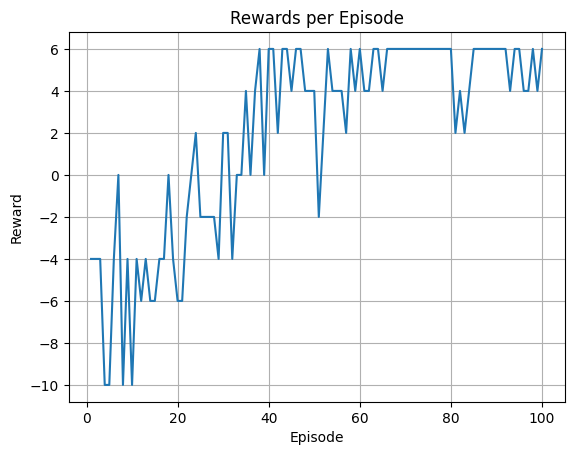

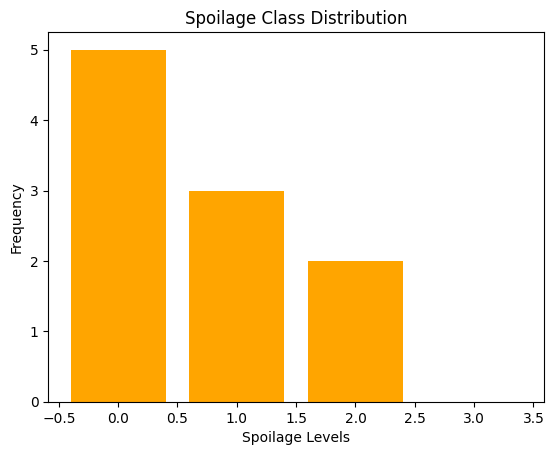

In [ ]:
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Environment for Spoilage Tracking
class SpoilageEnv(Env):
    def __init__(self):
        self.current_step = 0
        self.data = self.load_hardware_data()
        self.num_entries = len(self.data)
        self.action_space = Discrete(4)  # Four actions representing spoilage levels
        self.observation_space = Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.spoilage_thresholds = {
            'Temperature': 28.5,
            'Humidity': 92,
            'MQ3': 270,
            'MQ4': 340,
        }

    def load_hardware_data(self):
        # Replace this part with the actual data obtained from your hardware
        data = {
            'Temperature': [28.50, 28.50, 28.20, 28.10, 28.00, 28.00, 28.50, 28.10, 28.30, 28.00],
            'Humidity': [92.00, 92.00, 91.00, 91.00, 92.00, 92.00, 91.00, 92.00, 92.00, 91.00],
            'MQ3': [245, 243, 240, 199, 284, 281, 267, 265, 264, 253],
            'MQ4': [197, 194, 192, 270, 287, 332, 333, 351, 349, 353],
        }
        return pd.DataFrame(data)

    def step(self, action):
        state = self._next_observation()
        true_spoilage_level = self.get_spoilage_level(state)
        reward = 1 if true_spoilage_level == action else -1
        self.current_step += 1
        done = self.current_step >= self.num_entries
        return state, reward, done, {}

    def _next_observation(self):
        observation = self.data.iloc[self.current_step][['Temperature', 'Humidity', 'MQ3', 'MQ4']].values
        return np.reshape(observation, (1, len(observation), 1))

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def get_spoilage_level(self, state):
        temperature = state[0][0][0]
        humidity = state[0][1][0]
        if temperature > self.spoilage_thresholds['Temperature'] and humidity > self.spoilage_thresholds['Humidity']:
            return 3  # High spoilage
        elif state[0][2][0] > self.spoilage_thresholds['MQ3']:
            return 2  # Moderate spoilage
        elif state[0][3][0] > self.spoilage_thresholds['MQ4']:
            return 1  # Low spoilage
        else:
            return 0  # No spoilage

# DQN Agent with LSTM only
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            LSTM(64, input_shape=(self.state_dim, 1), activation='relu'),
            Dense(self.action_dim, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=self.lr), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            return np.argmax(self.model.predict(state)[0])

    def train(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
        target_f = self.model.predict(state)
        target_f[0][action] = target
        self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Environment and agent initialization
state_dim = 4
action_dim = 4
env = SpoilageEnv()
agent = DQNAgent(state_dim, action_dim)

# Training setup
num_episodes = 100
rewards_per_episode = []

for episode in range(1, num_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(env.num_entries):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.train(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        if done:
            break
    rewards_per_episode.append(episode_reward)
    print(f"Episode: {episode}, Reward: {episode_reward}")

# Plotting rewards per episode
plt.plot(range(1, num_episodes + 1), rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.grid(True)
plt.show()

# Additional metric: Spoilage Class Distribution
class_counts = {action: 0 for action in range(env.action_space.n)}
for _, true_action in env.data.iterrows():
    # Construct the correct state format
    state = np.array([
        [true_action['Temperature']],
        [true_action['Humidity']],
        [true_action['MQ3']],
        [true_action['MQ4']]
    ]).reshape(1, 4, 1)  # Ensure it matches the 3D array format
    spoilage_level = env.get_spoilage_level(state)
    class_counts[spoilage_level] += 1

# Plot the spoilage class distribution
plt.bar(class_counts.keys(), class_counts.values(), color='orange')
plt.xlabel("Spoilage Levels")
plt.ylabel("Frequency")
plt.title("Spoilage Class Distribution")
plt.show()



RNN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Episode: 1, Reward: -8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

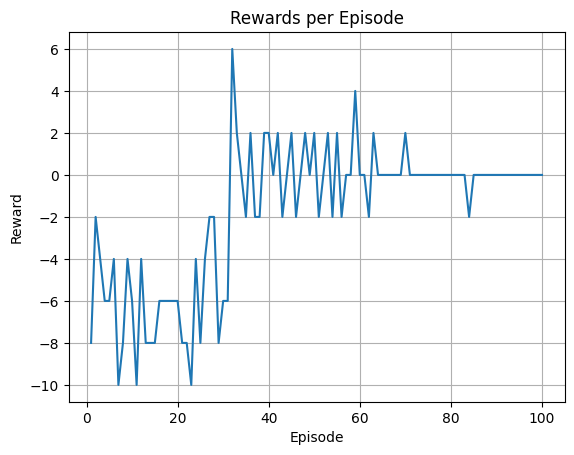

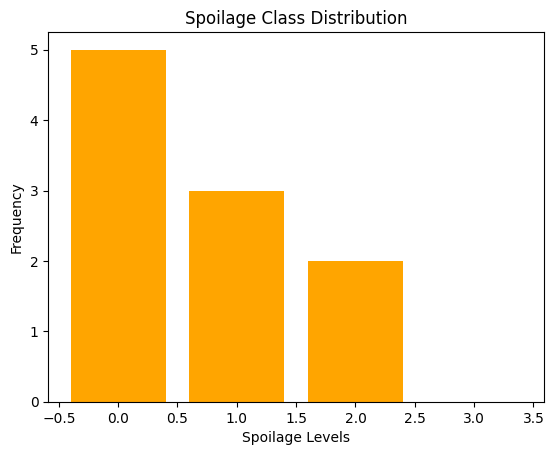

In [ ]:
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Spoilage Tracking Environment
class SpoilageEnv(Env):
    def __init__(self):
        self.current_step = 0
        self.data = self.load_hardware_data()
        self.num_entries = len(self.data)
        self.action_space = Discrete(4)  # Four actions representing spoilage levels
        self.observation_space = Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.spoilage_thresholds = {
            'Temperature': 28.5,
            'Humidity': 92,
            'MQ3': 270,
            'MQ4': 340,
        }

    def load_hardware_data(self):
        # Replace this with actual data from hardware
        data = {
            'Temperature': [28.50, 28.50, 28.20, 28.10, 28.00, 28.00, 28.50, 28.10, 28.30, 28.00],
            'Humidity': [92.00, 92.00, 91.00, 91.00, 92.00, 92.00, 91.00, 92.00, 92.00, 91.00],
            'MQ3': [245, 243, 240, 199, 284, 281, 267, 265, 264, 253],
            'MQ4': [197, 194, 192, 270, 287, 332, 333, 351, 349, 353],
        }
        return pd.DataFrame(data)

    def step(self, action):
        state = self._next_observation()
        true_spoilage_level = self.get_spoilage_level(state)
        reward = 1 if true_spoilage_level == action else -1
        self.current_step += 1
        done = self.current_step >= self.num_entries
        return state, reward, done, {}

    def _next_observation(self):
        observation = self.data.iloc[self.current_step][['Temperature', 'Humidity', 'MQ3', 'MQ4']].values
        return np.reshape(observation, (1, len(observation), 1))

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def get_spoilage_level(self, state):
        temperature = state[0][0][0]
        humidity = state[0][1][0]
        if temperature > self.spoilage_thresholds['Temperature'] and humidity > self.spoilage_thresholds['Humidity']:
            return 3  # High spoilage
        elif state[0][2][0] > self.spoilage_thresholds['MQ3']:
            return 2  # Moderate spoilage
        elif state[0][3][0] > self.spoilage_thresholds['MQ4']:
            return 1  # Low spoilage
        else:
            return 0  # No spoilage

# DQN Agent with RNN only
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            SimpleRNN(64, input_shape=(self.state_dim, 1), activation='relu'),
            Dense(self.action_dim, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=self.lr), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            return np.argmax(self.model.predict(state)[0])

    def train(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
        target_f = self.model.predict(state)
        target_f[0][action] = target
        self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Initialize Environment and Agent
state_dim = 4
action_dim = 4
env = SpoilageEnv()
agent = DQNAgent(state_dim, action_dim)

# Training parameters
num_episodes = 100
rewards_per_episode = []

# Main training loop
for episode in range(1, num_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(env.num_entries):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.train(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        if done:
            break
    rewards_per_episode.append(episode_reward)
    print(f"Episode: {episode}, Reward: {episode_reward}")

# Plotting rewards per episode
plt.plot(range(1, num_episodes + 1), rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.grid(True)
plt.show()

# Additional metric: Spoilage Class Distribution
class_counts = {action: 0 for action in range(env.action_space.n)}
for _, true_action in env.data.iterrows():
    # Construct the correct state format
    state = np.array([
        [true_action['Temperature']],
        [true_action['Humidity']],
        [true_action['MQ3']],
        [true_action['MQ4']]
    ]).reshape(1, 4, 1)  # Ensure it matches the 3D array format
    spoilage_level = env.get_spoilage_level(state)
    class_counts[spoilage_level] += 1

# Plot the spoilage class distribution
plt.bar(class_counts.keys(), class_counts.values(), color='orange')
plt.xlabel("Spoilage Levels")
plt.ylabel("Frequency")
plt.title("Spoilage Class Distribution")
plt.show()


ANN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Episode: 1, Reward: -6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

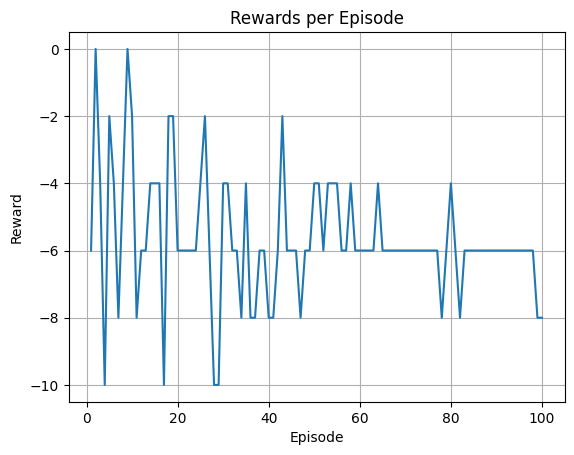

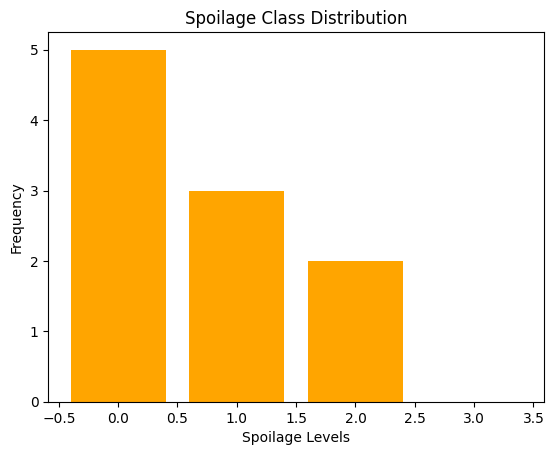

In [ ]:
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Spoilage Tracking Environment
class SpoilageEnv(Env):
    def __init__(self):
        self.current_step = 0
        self.data = self.load_hardware_data()
        self.num_entries = len(self.data)
        self.action_space = Discrete(4)  # Four actions representing spoilage levels
        self.observation_space = Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.spoilage_thresholds = {
            'Temperature': 28.5,
            'Humidity': 92,
            'MQ3': 270,
            'MQ4': 340,
        }

    def load_hardware_data(self):
        # Replace this with actual data from hardware
        data = {
            'Temperature': [28.50, 28.50, 28.20, 28.10, 28.00, 28.00, 28.50, 28.10, 28.30, 28.00],
            'Humidity': [92.00, 92.00, 91.00, 91.00, 92.00, 92.00, 91.00, 92.00, 92.00, 91.00],
            'MQ3': [245, 243, 240, 199, 284, 281, 267, 265, 264, 253],
            'MQ4': [197, 194, 192, 270, 287, 332, 333, 351, 349, 353],
        }
        return pd.DataFrame(data)

    def step(self, action):
        state = self._next_observation()
        true_spoilage_level = self.get_spoilage_level(state)
        reward = 1 if true_spoilage_level == action else -1
        self.current_step += 1
        done = self.current_step >= self.num_entries
        return state, reward, done, {}

    def _next_observation(self):
        observation = self.data.iloc[self.current_step][['Temperature', 'Humidity', 'MQ3', 'MQ4']].values
        return np.reshape(observation, (1, len(observation)))  # Flattened for ANN

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def get_spoilage_level(self, state):
        temperature = state[0][0]
        humidity = state[0][1]
        if temperature > self.spoilage_thresholds['Temperature'] and humidity > self.spoilage_thresholds['Humidity']:
            return 3  # High spoilage
        elif state[0][2] > self.spoilage_thresholds['MQ3']:
            return 2  # Moderate spoilage
        elif state[0][3] > self.spoilage_thresholds['MQ4']:
            return 1  # Low spoilage
        else:
            return 0  # No spoilage

# DQN Agent with ANN only
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Dense(64, input_dim=self.state_dim, activation='relu'),
            Dense(64, activation='relu'),
            Dense(self.action_dim, activation='linear')  # Output layer for Q-values
        ])
        model.compile(optimizer=Adam(learning_rate=self.lr), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            return np.argmax(self.model.predict(state)[0])

    def train(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
        target_f = self.model.predict(state)
        target_f[0][action] = target
        self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Initialize Environment and Agent
state_dim = 4
action_dim = 4
env = SpoilageEnv()
agent = DQNAgent(state_dim, action_dim)

# Training parameters
num_episodes = 100
rewards_per_episode = []

# Main training loop
for episode in range(1, num_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(env.num_entries):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.train(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        if done:
            break
    rewards_per_episode.append(episode_reward)
    print(f"Episode: {episode}, Reward: {episode_reward}")

# Plotting rewards per episode
plt.plot(range(1, num_episodes + 1), rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.grid(True)
plt.show()

# Additional metric: Spoilage Class Distribution
class_counts = {action: 0 for action in range(env.action_space.n)}
for _, true_action in env.data.iterrows():
    # Construct the correct state format
    state = np.array([
        [true_action['Temperature']],
        [true_action['Humidity']],
        [true_action['MQ3']],
        [true_action['MQ4']]
    ]).reshape(1, 4, 1)  # Ensure it matches the 3D array format
    spoilage_level = env.get_spoilage_level(state)
    class_counts[spoilage_level] += 1

# Plot the spoilage class distribution
plt.bar(class_counts.keys(), class_counts.values(), color='orange')
plt.xlabel("Spoilage Levels")
plt.ylabel("Frequency")
plt.title("Spoilage Class Distribution")
plt.show()


Value Iteration

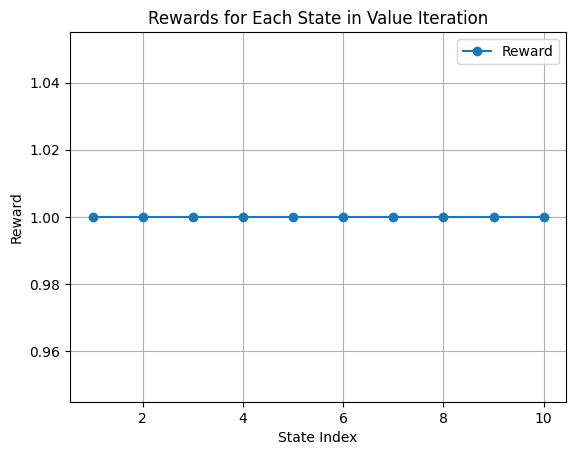

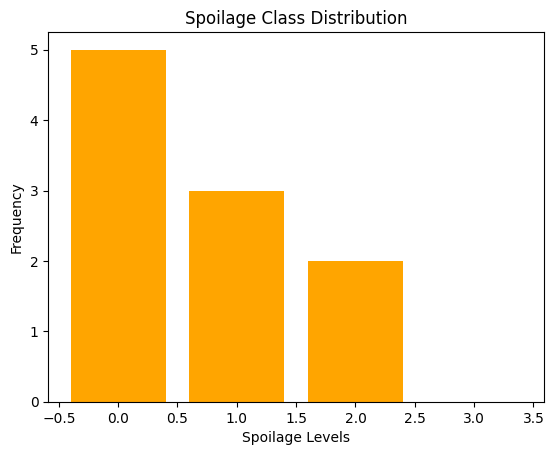

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import Env
from gym.spaces import Discrete, Box

# Spoilage Tracking Environment
class SpoilageEnv(Env):
    def __init__(self):
        self.current_step = 0
        self.data = self.load_hardware_data()
        self.num_entries = len(self.data)
        self.action_space = Discrete(4)  # Four actions representing spoilage levels
        self.observation_space = Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.spoilage_thresholds = {
            'Temperature': 28.5,
            'Humidity': 92,
            'MQ3': 270,
            'MQ4': 340,
        }

    def load_hardware_data(self):
        # Replace this with actual data from hardware
        data = {
            'Temperature': [28.50, 28.50, 28.20, 28.10, 28.00, 28.00, 28.50, 28.10, 28.30, 28.00],
            'Humidity': [92.00, 92.00, 91.00, 91.00, 92.00, 92.00, 91.00, 92.00, 92.00, 91.00],
            'MQ3': [245, 243, 240, 199, 284, 281, 267, 265, 264, 253],
            'MQ4': [197, 194, 192, 270, 287, 332, 333, 351, 349, 353],
        }
        return pd.DataFrame(data)

    def step(self, action):
        if self.current_step >= self.num_entries:  # Prevent out-of-bounds access
            raise IndexError("current_step is out-of-bounds")
        state = self._next_observation()
        true_spoilage_level = self.get_spoilage_level(state)
        reward = 1 if true_spoilage_level == action else -1
        self.current_step += 1
        done = self.current_step >= self.num_entries
        return state, reward, done, {}

    def _next_observation(self):
        observation = self.data.iloc[self.current_step][['Temperature', 'Humidity', 'MQ3', 'MQ4']].values
        return observation  # Flattened for processing

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def get_spoilage_level(self, state):
        temperature = state[0]
        humidity = state[1]
        if temperature > self.spoilage_thresholds['Temperature'] and humidity > self.spoilage_thresholds['Humidity']:
            return 3  # High spoilage
        elif state[2] > self.spoilage_thresholds['MQ3']:
            return 2  # Moderate spoilage
        elif state[3] > self.spoilage_thresholds['MQ4']:
            return 1  # Low spoilage
        else:
            return 0  # No spoilage

# Value Iteration Function
def value_iteration(env, gamma=0.99, theta=0.0001):
    V = np.zeros(env.num_entries)  # Value function initialization
    policy = np.zeros(env.num_entries, dtype=int)

    while True:
        delta = 0
        for state_idx in range(env.num_entries):
            state = env.data.iloc[state_idx][['Temperature', 'Humidity', 'MQ3', 'MQ4']].values

            best_value = -float('inf')
            best_action = None

            # Iterate over all actions
            for action in range(env.action_space.n):
                true_spoilage_level = env.get_spoilage_level(state)
                reward = 1 if true_spoilage_level == action else -1
                value = reward + gamma * V[state_idx]  # Bellman update

                if value > best_value:
                    best_value = value
                    best_action = action

            # Update value function and policy
            delta = max(delta, abs(V[state_idx] - best_value))
            V[state_idx] = best_value
            policy[state_idx] = best_action

        if delta < theta:  # Convergence check
            break

    return V, policy

# Initialize environment
env = SpoilageEnv()

# Run value iteration to get optimal value function and policy
V, policy = value_iteration(env)

# Extracting the reward for each state
rewards = []
for state_idx in range(env.num_entries):
    state = env.data.iloc[state_idx][['Temperature', 'Humidity', 'MQ3', 'MQ4']].values
    action = policy[state_idx]
    reward = 1 if action == env.get_spoilage_level(state) else -1
    rewards.append(reward)

# Plotting rewards per state (equivalent to an episode)
plt.plot(range(1, len(rewards) + 1), rewards, marker='o', label='Reward')
plt.xlabel('State Index')
plt.ylabel('Reward')
plt.title('Rewards for Each State in Value Iteration')
plt.grid(True)
plt.legend()
plt.show()

# Additional metric: Spoilage Class Distribution
class_counts = {action: 0 for action in range(env.action_space.n)}
for _, row in env.data.iterrows():
    state = np.array([row['Temperature'], row['Humidity'], row['MQ3'], row['MQ4']])
    spoilage_level = env.get_spoilage_level(state)
    class_counts[spoilage_level] += 1

# Plot the spoilage class distribution
plt.bar(class_counts.keys(), class_counts.values(), color='orange')
plt.xlabel("Spoilage Levels")
plt.ylabel("Frequency")
plt.title("Spoilage Class Distribution")
plt.show()


Q-Learning

Episode 1/100, Reward: -1, Epsilon: 0.99
Episode 2/100, Reward: -1, Epsilon: 0.99
Episode 3/100, Reward: -1, Epsilon: 0.99
Episode 4/100, Reward: -1, Epsilon: 0.98
Episode 5/100, Reward: -1, Epsilon: 0.98
Episode 6/100, Reward: 1, Epsilon: 0.97
Episode 7/100, Reward: -1, Epsilon: 0.97
Episode 8/100, Reward: -1, Epsilon: 0.96
Episode 9/100, Reward: -1, Epsilon: 0.96
Episode 10/100, Reward: 1, Epsilon: 0.95
Episode 11/100, Reward: 1, Epsilon: 0.95
Episode 12/100, Reward: -1, Epsilon: 0.94
Episode 13/100, Reward: -1, Epsilon: 0.94
Episode 14/100, Reward: 1, Epsilon: 0.93
Episode 15/100, Reward: -1, Epsilon: 0.93
Episode 16/100, Reward: -1, Epsilon: 0.92
Episode 17/100, Reward: -1, Epsilon: 0.92
Episode 18/100, Reward: 1, Epsilon: 0.91
Episode 19/100, Reward: -1, Epsilon: 0.91
Episode 20/100, Reward: -1, Epsilon: 0.90
Episode 21/100, Reward: -1, Epsilon: 0.90
Episode 22/100, Reward: -1, Epsilon: 0.90
Episode 23/100, Reward: -1, Epsilon: 0.89
Episode 24/100, Reward: 1, Epsilon: 0.89
Episode

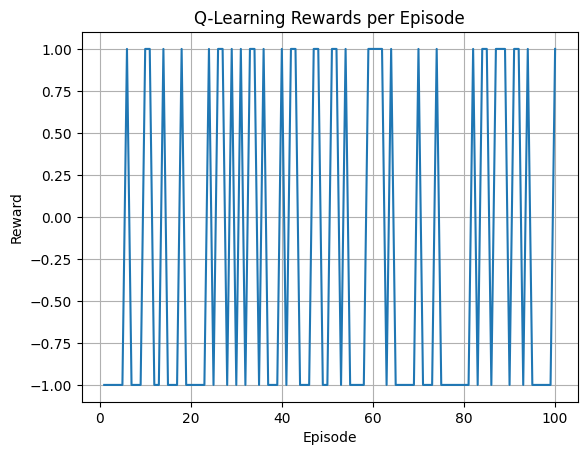

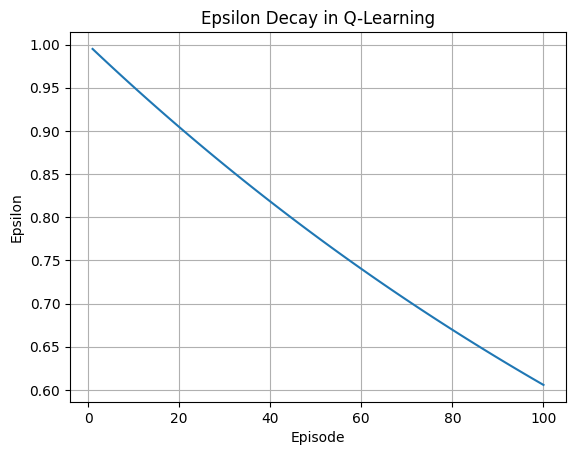

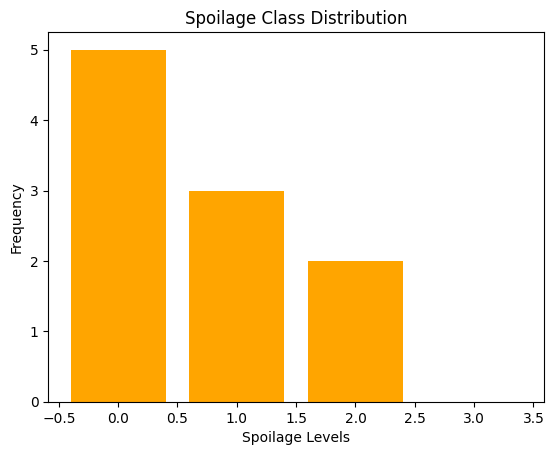

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import Env
from gym.spaces import Discrete, Box

# Spoilage Tracking Environment
class SpoilageEnv(Env):
    def __init__(self):
        self.current_step = 0
        self.data = self.load_hardware_data()
        self.num_entries = len(self.data)
        self.action_space = Discrete(4)  # Four actions representing spoilage levels
        self.observation_space = Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.spoilage_thresholds = {
            'Temperature': 28.5,
            'Humidity': 92,
            'MQ3': 270,
            'MQ4': 340,
        }

    def load_hardware_data(self):
        # Replace this with actual data from hardware
        data = {
            'Temperature': [28.50, 28.50, 28.20, 28.10, 28.00, 28.00, 28.50, 28.10, 28.30, 28.00],
            'Humidity': [92.00, 92.00, 91.00, 91.00, 92.00, 92.00, 91.00, 92.00, 92.00, 91.00],
            'MQ3': [245, 243, 240, 199, 284, 281, 267, 265, 264, 253],
            'MQ4': [197, 194, 192, 270, 287, 332, 333, 351, 349, 353],
        }
        return pd.DataFrame(data)

    def step(self, action):
        state = self._next_observation()
        true_spoilage_level = self.get_spoilage_level(state)
        reward = 1 if true_spoilage_level == action else -1
        self.current_step += 1
        done = self.current_step >= self.num_entries
        return state, reward, done, {}

    def _next_observation(self):
        observation = self.data.iloc[self.current_step][['Temperature', 'Humidity', 'MQ3', 'MQ4']].values
        return np.reshape(observation, (1, len(observation)))  # Flattened for ANN

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def get_spoilage_level(self, state):
        temperature = state[0][0]
        humidity = state[0][1]
        if temperature > self.spoilage_thresholds['Temperature'] and humidity > self.spoilage_thresholds['Humidity']:
            return 3  # High spoilage
        elif state[0][2] > self.spoilage_thresholds['MQ3']:
            return 2  # Moderate spoilage
        elif state[0][3] > self.spoilage_thresholds['MQ4']:
            return 1  # Low spoilage
        else:
            return 0  # No spoilage

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, state_dim, action_dim, lr=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((state_dim, action_dim))  # Initialize Q-table

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)  # Random action (exploration)
        else:
            return np.argmax(self.q_table[state])  # Best action (exploitation)

    def train(self, state, action, reward, next_state, done):
        # Update Q-value based on the Bellman equation
        future_q = np.max(self.q_table[next_state]) if not done else 0
        self.q_table[state, action] += self.lr * (reward + self.gamma * future_q - self.q_table[state, action])

        # Epsilon decay for exploration
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Initialize environment and agent
env = SpoilageEnv()
agent = QLearningAgent(state_dim=env.num_entries, action_dim=env.action_space.n)

# Training parameters
num_episodes = 100
max_steps_per_episode = 1

# Lists to store rewards and episode data
episode_rewards = []
epsilon_values = []

# Main Q-Learning training loop
for episode in range(1, num_episodes + 1):
    state = env.reset()
    episode_reward = 0

    for step in range(max_steps_per_episode):
        state_idx = state[0].argmax()  # Converting state to index for simplicity
        action = agent.act(state_idx)
        next_state, reward, done, _ = env.step(action)

        # Update Q-table
        agent.train(state_idx, action, reward, state_idx, done)

        episode_reward += reward
        state = next_state

        if done:
            break

    # Append data for plotting
    episode_rewards.append(episode_reward)
    epsilon_values.append(agent.epsilon)

    # Print progress
    print(f"Episode {episode}/{num_episodes}, Reward: {episode_reward}, Epsilon: {agent.epsilon:.2f}")

# Plotting the rewards per episode
plt.plot(range(1, num_episodes + 1), episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Q-Learning Rewards per Episode')
plt.grid(True)
plt.show()

# Plotting the epsilon decay
plt.plot(range(1, num_episodes + 1), epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay in Q-Learning')
plt.grid(True)
plt.show()
# Additional metric: Spoilage Class Distribution
class_counts = {action: 0 for action in range(env.action_space.n)}
for _, true_action in env.data.iterrows():
    # Construct the correct state format
    state = np.array([
        [true_action['Temperature']],
        [true_action['Humidity']],
        [true_action['MQ3']],
        [true_action['MQ4']]
    ]).reshape(1, 4, 1)  # Ensure it matches the 3D array format
    spoilage_level = env.get_spoilage_level(state)
    class_counts[spoilage_level] += 1

# Plot the spoilage class distribution
plt.bar(class_counts.keys(), class_counts.values(), color='orange')
plt.xlabel("Spoilage Levels")
plt.ylabel("Frequency")
plt.title("Spoilage Class Distribution")
plt.show()


Monte Carlo

Episode 1/100, Reward: -1, Epsilon: 0.99
Episode 2/100, Reward: 1, Epsilon: 0.99
Episode 3/100, Reward: 1, Epsilon: 0.99
Episode 4/100, Reward: -1, Epsilon: 0.98
Episode 5/100, Reward: -1, Epsilon: 0.98
Episode 6/100, Reward: 1, Epsilon: 0.97
Episode 7/100, Reward: 1, Epsilon: 0.97
Episode 8/100, Reward: 1, Epsilon: 0.96
Episode 9/100, Reward: -1, Epsilon: 0.96
Episode 10/100, Reward: -1, Epsilon: 0.95
Episode 11/100, Reward: 1, Epsilon: 0.95
Episode 12/100, Reward: 1, Epsilon: 0.94
Episode 13/100, Reward: -1, Epsilon: 0.94
Episode 14/100, Reward: 1, Epsilon: 0.93
Episode 15/100, Reward: -1, Epsilon: 0.93
Episode 16/100, Reward: -1, Epsilon: 0.92
Episode 17/100, Reward: 1, Epsilon: 0.92
Episode 18/100, Reward: -1, Epsilon: 0.91
Episode 19/100, Reward: -1, Epsilon: 0.91
Episode 20/100, Reward: 1, Epsilon: 0.90
Episode 21/100, Reward: 1, Epsilon: 0.90
Episode 22/100, Reward: 1, Epsilon: 0.90
Episode 23/100, Reward: -1, Epsilon: 0.89
Episode 24/100, Reward: 1, Epsilon: 0.89
Episode 25/100

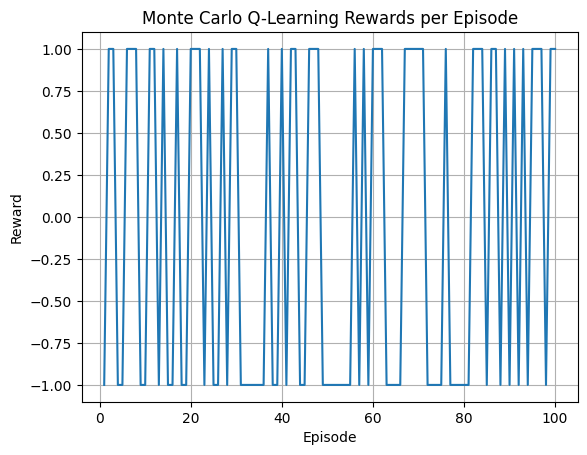

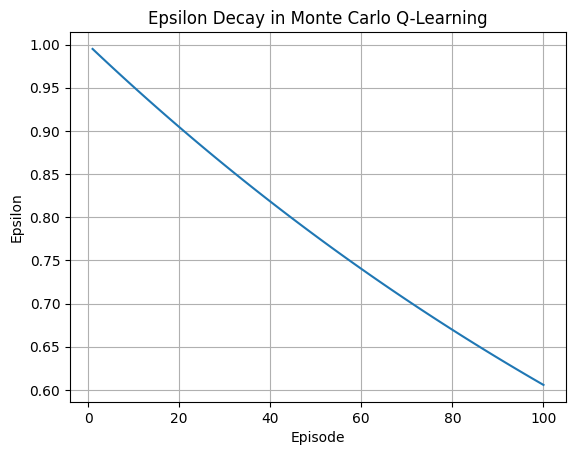

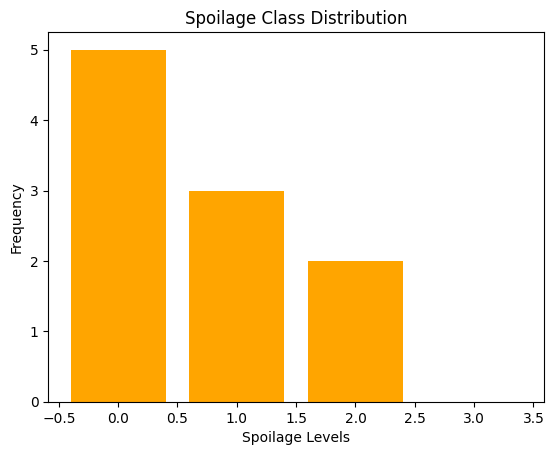

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import Env
from gym.spaces import Discrete, Box

# Spoilage Tracking Environment
class SpoilageEnv(Env):
    def __init__(self):
        self.current_step = 0
        self.data = self.load_hardware_data()
        self.num_entries = len(self.data)
        self.action_space = Discrete(4)  # Four actions representing spoilage levels
        self.observation_space = Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.spoilage_thresholds = {
            'Temperature': 28.5,
            'Humidity': 92,
            'MQ3': 270,
            'MQ4': 340,
        }

    def load_hardware_data(self):
        # Replace this with actual data from hardware
        data = {
            'Temperature': [28.50, 28.50, 28.20, 28.10, 28.00, 28.00, 28.50, 28.10, 28.30, 28.00],
            'Humidity': [92.00, 92.00, 91.00, 91.00, 92.00, 92.00, 91.00, 92.00, 92.00, 91.00],
            'MQ3': [245, 243, 240, 199, 284, 281, 267, 265, 264, 253],
            'MQ4': [197, 194, 192, 270, 287, 332, 333, 351, 349, 353],
        }
        return pd.DataFrame(data)

    def step(self, action):
        state = self._next_observation()
        true_spoilage_level = self.get_spoilage_level(state)
        reward = 1 if true_spoilage_level == action else -1
        self.current_step += 1
        done = self.current_step >= self.num_entries
        return state, reward, done, {}

    def _next_observation(self):
        observation = self.data.iloc[self.current_step][['Temperature', 'Humidity', 'MQ3', 'MQ4']].values
        return np.reshape(observation, (1, len(observation)))  # Flattened for ANN

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def get_spoilage_level(self, state):
        temperature = state[0][0]
        humidity = state[0][1]
        if temperature > self.spoilage_thresholds['Temperature'] and humidity > self.spoilage_thresholds['Humidity']:
            return 3  # High spoilage
        elif state[0][2] > self.spoilage_thresholds['MQ3']:
            return 2  # Moderate spoilage
        elif state[0][3] > self.spoilage_thresholds['MQ4']:
            return 1  # Low spoilage
        else:
            return 0  # No spoilage

# Monte Carlo Q-Learning Agent
class MCQLearningAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((state_dim, action_dim))  # Initialize Q-table
        self.state_action_rewards = []  # To store (state, action, reward) tuples for Monte Carlo

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)  # Random action (exploration)
        else:
            return np.argmax(self.q_table[state])  # Best action (exploitation)

    def store_episode(self, state, action, reward):
        self.state_action_rewards.append((state, action, reward))

    def update_q_values(self):
        # Calculate returns and update Q-values
        returns = 0
        for state, action, reward in reversed(self.state_action_rewards):
            returns = reward + self.gamma * returns
            self.q_table[state, action] += (returns - self.q_table[state, action])

        # Clear the episode's data after updating Q-values
        self.state_action_rewards = []

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Initialize environment and agent
env = SpoilageEnv()
agent = MCQLearningAgent(state_dim=env.num_entries, action_dim=env.action_space.n)

# Training parameters
num_episodes = 100
max_steps_per_episode = 1

# Lists to store rewards and episode data
episode_rewards = []
epsilon_values = []

# Main Monte Carlo training loop
for episode in range(1, num_episodes + 1):
    state = env.reset()
    episode_reward = 0

    for step in range(max_steps_per_episode):
        state_idx = state[0].argmax()  # Converting state to index for simplicity
        action = agent.act(state_idx)
        next_state, reward, done, _ = env.step(action)

        # Store the (state, action, reward) tuple for Monte Carlo update
        agent.store_episode(state_idx, action, reward)

        episode_reward += reward
        state = next_state

        if done:
            break

    # Update Q-values based on the collected episode data
    agent.update_q_values()

    # Epsilon decay
    agent.decay_epsilon()

    # Append data for plotting
    episode_rewards.append(episode_reward)
    epsilon_values.append(agent.epsilon)

    # Print progress
    print(f"Episode {episode}/{num_episodes}, Reward: {episode_reward}, Epsilon: {agent.epsilon:.2f}")

# Plotting the rewards per episode
plt.plot(range(1, num_episodes + 1), episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Monte Carlo Q-Learning Rewards per Episode')
plt.grid(True)
plt.show()

# Plotting the epsilon decay
plt.plot(range(1, num_episodes + 1), epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay in Monte Carlo Q-Learning')
plt.grid(True)
plt.show()
# Additional metric: Spoilage Class Distribution
class_counts = {action: 0 for action in range(env.action_space.n)}
for _, true_action in env.data.iterrows():
    # Construct the correct state format
    state = np.array([
        [true_action['Temperature']],
        [true_action['Humidity']],
        [true_action['MQ3']],
        [true_action['MQ4']]
    ]).reshape(1, 4, 1)  # Ensure it matches the 3D array format
    spoilage_level = env.get_spoilage_level(state)
    class_counts[spoilage_level] += 1

# Plot the spoilage class distribution
plt.bar(class_counts.keys(), class_counts.values(), color='orange')
plt.xlabel("Spoilage Levels")
plt.ylabel("Frequency")
plt.title("Spoilage Class Distribution")
plt.show()
